# Стадия I

Программа принимает на вход скорости и координаты космических объектов и рассчитывает их положение и скорость в зависимости от времени методом численного решения уравнений Ньютона. Обоснован выбор разностной схемы и шага интеграции. Требуемая точность - отклонение от аналитической орбиты до 10 cм за неделю на орбитах высотой от 300 до 1200 км для модели с единственной силой - точечной гравитацией. Если это не достигается на стандартных типах данных, докажите, обсудим. Расчёт на GPU

Все расчёты в системе единиц СИ. Чтобы так не получилось.

Есть код, генерирующий случайные начальные условия для 21000 объектов. Круговые орбиты, высота распределена по Гауссу, средняя 800 км, дисперсия 200 км, плоскости - равномерно. Размеры объектов от 1 см до 10 м, распределены с pdf = 1/object_size

В коде есть интерфейс для простого добавления новых сил, действующих на объекты. Силы могут зависеть от времени, скорости и координат объекта, параметров объекта. В нём реализована элементарная модель гравитации, где Земля - шар.

Есть визуализатор, для заданных id объектов и интервалу времени, рисующий их траекторию картинкой. В отчёте есть траектории 10 случайных объектов на протяжении суток.


In [1]:
import os
import matplotlib.pyplot as plt
import subprocess
import json
import math
from matplotlib import pyplot
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
!cd ../ &&\
nvcc src/gpu_main.cu \
src/gpu/gpu_solver.cu \
src/model.cu \
-o bin/gpu_spacejunk.exe

src/gpu/gpu_solver.cu(25): warning: variable "M" was declared but never referenced

src/gpu/gpu_solver.cu(26): warning: variable "G" was declared but never referenced

src/gpu/gpu_solver.cu(110): warning: variable "dt1" was declared but never referenced

src/gpu/gpu_solver.cu(111): warning: variable "dh" was declared but never referenced



## 1 - Сравнение с аналитической орбитой

По заданию - Требуемая точность - отклонение от аналитической орбиты до 10 cм за неделю на орбитах высотой от 300 до 1200 км для модели с единственной силой - точечной гравитацией. 

In [3]:
# !pip3 install pykep --user

In [4]:
import pykep as pk
def kepler_sim(r, v, t, mu, N=60, units=1, color='b', legend=False, ax=None):
    """
    ax = plot_kepler(r, v, t, mu, N=60, units=1, color='b', legend=False, ax=None):
    - ax:		3D axis object created using fig.gca(projection='3d')
    - r:		initial position (cartesian coordinates)
    - v:		initial velocity (cartesian coordinates)
    - t:		propagation time
    - mu:		gravitational parameter
    - N:		number of points to be plotted along one arc
    - units:	the length unit to be used in the plot
    - color:	matplotlib color to use to plot the line
    - legend	when True it plots also the legend
    Plots the result of a keplerian propagation
    """

    from pykep import propagate_lagrangian
    import matplotlib.pylab as plt
    from mpl_toolkits.mplot3d import Axes3D

    if ax is None:
        fig = plt.figure()
        axis = fig.gca(projection='3d')
    else:
        axis = ax

    # We define the integration time ...
    dt = t / (N - 1)

    # ... and calculate the cartesian components for r
    x = [0.0] * N
    y = [0.0] * N
    z = [0.0] * N

    # We calculate the spacecraft position at each dt
    for i in range(N):
        x[i] = r[0] / units
        y[i] = r[1] / units
        z[i] = r[2] / units
        r, v = pk.propagate_lagrangian(r, v, dt, mu)

    # And we plot
    if legend:
        label = 'ballistic arc'
    else:
        label = None
    axis.plot(x, y, z, c=color, label=label)

    if legend:
        axis.legend()

    if ax is None:  # show only if axis is not set
        plt.show()
    return axis, x, y, z

In [5]:
def run_simulation(time, dt, 
                   steps, max_steps, 
                   objects, forces, 
                   log_trajectories=[0], 
                   collision_option="disabled"):
    """Python wrapper for execute cuda binary. Works via config files.
    Saves txt files with trajectories and collisions. 
    Объект - массив из 7 чисел: 
    x, y, z, vx, vy, vz, size - начальное положение, скорость и размер
    Args:
        time (double): время начала моделирования, с ()
        dt (double): интервал, через который считается новая позиция, с
        steps (int): кол-во итераций
        maxSteps (int): максимальное кол-во шагов, которое будет за 1 раз промоделировано на GPU
        objects (np.array): массив объектов. 
        forces (list of str): массив строк-идентификаторов сил
        log_trajectories (list of int): массив из индексов объектов
        collision_options (str): "disabled" - не ищем коллизии, если "slow" - то ищем за квадрат, иначе - ищем быстрым алгоритмом
        
    Returns:
        trajectories (dict): словарь {индекс объекта : массив из его траекторий}
        collisions (array): массив троек: (время, id объекта, id объекта)
        
    """
    with open("./cfg.txt", "w") as f:
        f.write(' '.join([str(x) for x in [time, dt, max_steps, steps]]) + '\n')
        f.write(str(len(objects)) + '\n')
        for obj in objects:
            f.write(' '.join([str(x) for x in obj]) + '\n')
        f.write(str(len(log_trajectories)) + '\n')
        f.write(' '.join([str(x) for x in log_trajectories]) + '\n')
        f.write(str(len(forces)) + '\n')
        f.write(' '.join(forces) + '\n')
        f.write("trajectories.txt\n")
        f.write("collisions.txt\n")
        f.write(collision_option)
        f.write("\n")
        
    FNULL = open(os.devnull, 'w')
    args = ["../bin/gpu_spacejunk.exe",  "./cfg.txt"]
    res = subprocess.call(args, stdout=FNULL, stderr=FNULL, shell=False)
    if res:
        return None
    
    trajectories = {}
    with open("trajectories.txt") as tr:
        if tr:
            line = tr.readline()
            cur_id = None
            while (line):
                coords = line.split()
                if len(coords) == 1:
                    cur_id = int(coords[0])
                    trajectories[cur_id] = []
                else:
                    trajectories[cur_id].append([float(x) for x in coords])
                line = tr.readline()
    
    collisions = []
    with open("collisions.txt") as coll:
        if coll:
            line = coll.readline()
            while (line):
                collision = line.split()
                collisions.append((float(collision[0]), int(collision[1]), int(collision[2])))
                line = coll.readline()
    return trajectories, collisions

def draw_trajectories(trajectories):
    fig = pyplot.figure()
    ax = Axes3D(fig)
    for index, points in trajectories.items():
        period = 1
        # Oooh
        if len(points) > 100:
            period = 1
            if len(points) > 1000:
                period = len(points) //100
                if len(points) > 100000:
                    period = len(points) //10000
      
        x_coord = [i[0] for i in points[::period]]
        y_coord = [i[1] for i in points[::period]]
        z_coord = [i[2] for i in points[::period]]
        ax.scatter(x_coord, y_coord, z_coord)
    pyplot.show()

Зададимся следующим обьектом. Расчет проведем для недели.

In [6]:
M = 5.972e24
R = 6.371e6
G = 6.67408e-11

x_obj = 0.0
y_obj = 1.2 * R
z_obj = 0.0

vx_obj = (G * M / (1.2 * R)) ** 0.5
vy_obj = 0.0
vz_obj = 0.0

MU =  3.986004418e14

timestep = 1.0
week = (1/timestep)*3600*24*7 
simulation_time = week
print('Simulation_time =', simulation_time, 'steps')

Simulation_time = 604800.0 steps


In [7]:
vx_obj

7220.398677765058

In [8]:
res = run_simulation(time = 0.0, 
                     dt = 1.0, 
                     steps =  int(simulation_time), 
                     max_steps = 10000, 
                     objects = [[x_obj, y_obj, z_obj,
                                vx_obj, vy_obj, vz_obj, 0]], 
                     forces = ['gravity'],
                     log_trajectories=[0])

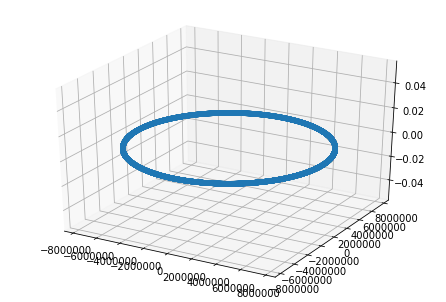

In [9]:
draw_trajectories(res[0])

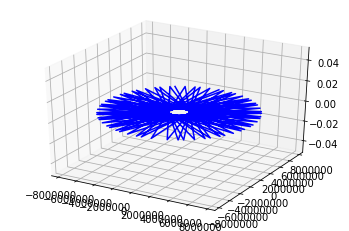

In [10]:
_ , x_keppler, y_keppler, z_keppler = \
kepler_sim([x_obj, y_obj, z_obj],
           [vx_obj, vy_obj, vz_obj], t=int(simulation_time) , mu = G*M )

График стремный потому что в pykep точки с шагом берутся, чтобы не грузить отрисовщик.

In [11]:
x_keppler[-1], y_keppler[-1], z_keppler[-1]

(-4159274.7179854093, 6414788.917830963, 0.0)

In [12]:
x_res, y_res, z_res = res[0][0][-1][:3]

Сравнение с PYKEP. Посмотрим на разницу за неделю.

In [13]:
 print(' x diff ', x_keppler[-1]-x_res, '\n', 
      'y_diff ', y_keppler[-1]-y_res, '\n', 
      'z_diff ', z_keppler[-1]-z_res)

 x diff  0.0002979380078613758 
 y_diff  0.00019227154552936554 
 z_diff  0.0


Нашим требованиям удовлетворяет.

# Несколько обьектов

In [14]:
import numpy as np
%cd ..
from  src.utils import *
%cd examples/

/data/ivpaharitonov/space_junk_simulator/space_junk_simulator
/data/ivpaharitonov/space_junk_simulator/space_junk_simulator/examples


Возьмем батч обьектов размера 21000 и промоделируем движение в течение суток.

In [16]:
N = 21000

space_objects = generate_object_states(N)


import pandas as pd
a = pd.DataFrame(space_objects).values

object_id = a[:, 0]
x_batch_init = a[:, 6].astype(np.float64)
y_batch_init = a[:, 7].astype(np.float64)
z_batch_init = a[:, 8].astype(np.float64)

vx_batch_init = a[:, 3].astype(np.float64)
vy_batch_init = a[:, 4].astype(np.float64)
vz_batch_init = a[:, 5].astype(np.float64)

In [17]:
objects = [[item['x'], item['y'],  item['z'],
 item['vx'], item['vy'],  item['vz'], 
 item['size']]  for item in space_objects]

In [18]:
timestep = 1.0
day = (1/timestep)*3600*24
simulation_time = day
print('Simulation_time =', simulation_time, 'steps')

Simulation_time = 86400.0 steps


In [19]:
res = run_simulation(time = 0.0, 
                     dt = 10000, 
                     steps =  int(simulation_time), 
                     max_steps = 100000, 
                     objects = objects, 
                     forces = ['gravity'], 
                     log_trajectories=range(10), 
                     collision_option=["disabled"])

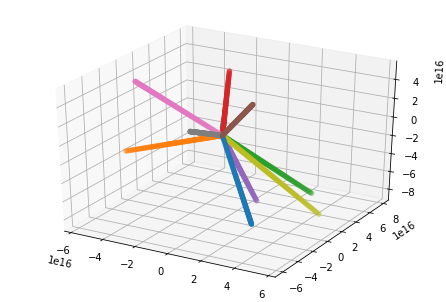

In [20]:
draw_trajectories(res[0])

In [21]:
def draw_trajectories_single(trajectories, object_id):
    fig = pyplot.figure()
    ax = Axes3D(fig)
    history = trajectories[object_id]
    
    if len(history) > 100:
        period = 1
        if len(history) > 800:
            period = len(history) //100
            if len(history) > 100000:
                period = len(history) //10000
                
                
    for points in history[::period]:
        x_coord, y_coord, z_coord = points[:3]
        ax.scatter(x_coord, y_coord, z_coord)
    pyplot.show()

9


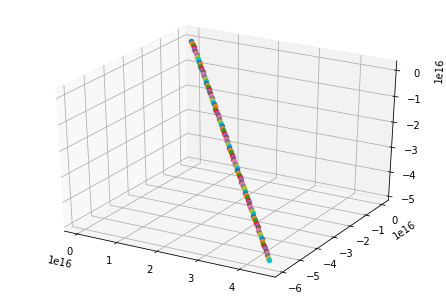

8


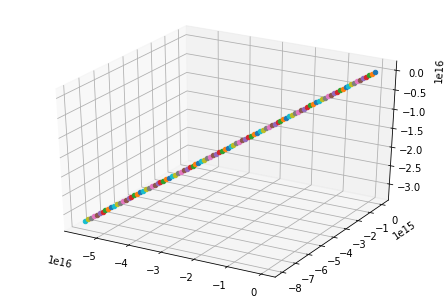

7


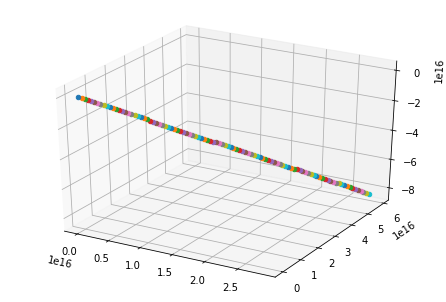

6


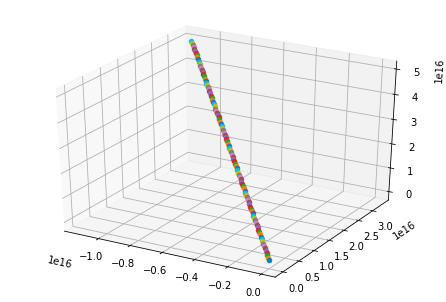

1


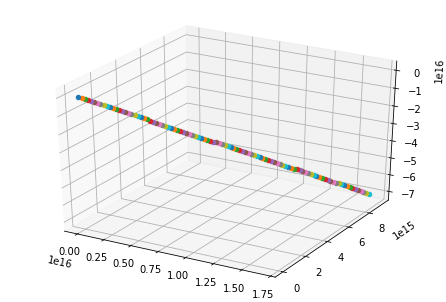

0


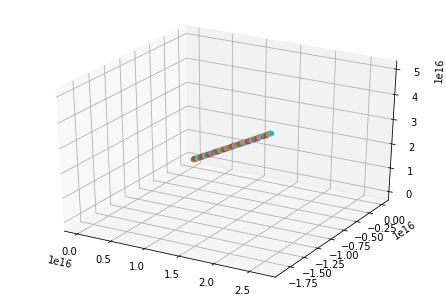

2


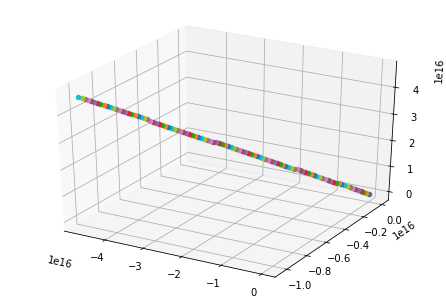

3


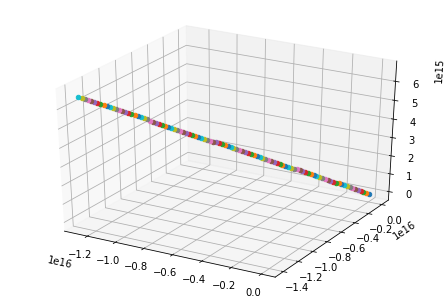

4


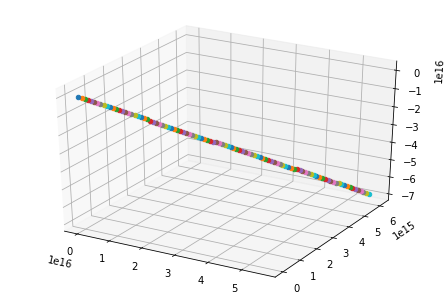

5


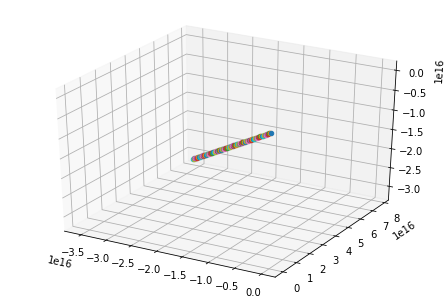

In [22]:
for object_log in res[0]:
    print(object_log)
    draw_trajectories_single(res[0], object_log)